In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import training_models_helper as tmh
%aimport training_models_helper

tm = tmh.TrainingModelsHelper()

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

kn = tmh.KNN_Helper()

import transform_helper
%aimport transform_helper

th = transform_helper.Transformation_Helper()

iph = transform_helper.InfluentialPoints_Helper()

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

# Improving prediction: Understanding the Loss function

In performing Error Analysis 
- we *identified* **test** examples where our model failed to generalize correctly
- but we didn't propose a **solution** to improve generalization

That is the topic of this module.

When we perform Error Analysis
- we focus on the Performance Metric (e.g., Accuracy)
- on a per-example basis
- for **out of sample** examples

But we can't *directly* influence the Performance on an out of sample example.

Instead, we will perform a *Loss Analysis*
- we focus on the Loss
- on a per-example basis
- for **in sample** examples

This is the analog of Error Analysis, but performed on Training rather than Test examples.

Reminder
- the Loss Function and Performance metrics are **not necessarily** the same
- the Loss Function is computed **in-sample**
- the Performance Metric is computed **out of sample**

The hope is
- that improving in-sample Loss
- will *indirectly* lead to a better out of sample Performance Metric

To illustrate, recall how Logistic Regression creates a prediction
- the model computes a score/logit for an example
$$
\hat{\mathbf{p}}^\ip = \sigma( \Theta^T \cdot \x^\ip )
$$
- the score/logit is converted into a prediction by comparison with a threshold
$$
\hat{\y}^\ip = 
\left\{
    {
    \begin{array}{lll}
     \text{Negative} & \textrm{if } \hat{\mathbf{p}}^\ip   < 0.5  \\
     \text{Positive}& \textrm{if } \hat{\mathbf{p}}^\ip \ge 0.5 
    \end{array}
    }
\right.
$$

The Loss is Binary Cross Entropy evaluated on the probabilities $\hat{\mathbf{p}}^\ip$

As we observed [before](Classification_Loss_Function.ipynb#Classification:-Loss-function)
- a small change in $\hat{\mathbf{p}}^\ip$
- does **not necessarily** change prediction $\y^\ip$
- unless $\hat{\mathbf{p}}^\ip$ crosses the threshold

Thus
- the Loss varies continuously with changes in parameters $\Theta$
- but the Performance **may not**


Loss Analysis
- examines the per-example Loss using in-sample examples
- in order to finding common attributes of problematic (mis-predicted) in-sample examples

Once we *diagnose* the problem with Loss
- we can explore remedies
    - feature engineering
    - pre-processing
- with the goal of causing the optimizer to change $\Theta$
- in order to push $\hat{\mathbf{p}}^\ip$ in the right direction

Recall the basics of minimizing Loss Functions
- Predictions $h(\x; \Theta)$  are a function of both inputs and parameters $\Theta$
- A given $\Theta$ induces a per-example loss $\loss_\Theta^\ip$
- Average Loss is the average of the per-examples losses $\loss_\Theta^\ip, i=1, \ldots, m$
- We seek the optimal $\Theta^*$: $$
\Theta^* = \argmin{\Theta} { \loss_\Theta }
$$

In pictures:


<table>
    <tr>
        <th><center>Training Example</center></th>
    </tr>
    <tr>
        <td><img src="images/W1_L4_s55_Intro_training.png"</td>
    </tr>
</table>
​


<table>
    <tr>
        <th><center>Training Example</center></th>
    </tr>
    <tr>
        <td><img src="images/Intro_error_analysis.png"</td>
    </tr>
</table>
•


# Conditional loss

In Error Analysis we partition test examples into groups with some common property, such as
- Commonality of result: TP, FN, TN, FP
- Commonality of features
in order to compute a *conditional* out of sample metric.

In Loss Analysis we partition training examples into groups to
in order to compute a *conditional* in sample metric.

The following picture uses colors to identify which group a training example belongs to:



<table>
    <tr>
        <th><center>Loss analysis: conditional loss</center></th>
    </tr>
    <tr>
        <td><img src="images/Intro_error_analysis_1.png"</td>
    </tr>
</table>


The real advantage of performing Conditional analysis in sample
- In sample examples (training/validation) can be re-used, unlike Test examples
- Added features based on in sample analysis is likely to affect the Loss
    - Unknown whether it will affect Performance Metric (when it is different than Loss, e.g., Accuracy)

## What can we do to reduce loss ?

Understanding the per example loss can help you "push" the optimizer toward find a "better" $\Theta$.

We will outline some simple strategies via examples that identify a probelm and propose a solution.



## Increase number of "problem" training example

For MNIST digit classification
- We hypothesize a commonality that causes images of the digit 8 to be mis-classified
    - 8's that are slanted in the "opposite" direction of normal
    - We will refer to this as the *problematic* class

One reason our classifier may fail on this sub-class of 8's
- There are many fewer of them than the more prevalent images of 8's

Mathematically, the Average Loss is equally weighted
$$
\loss_\Theta  = { 1\over{m} } \sum_{i=1}^m \loss^\ip_\Theta
$$

but the cumulative weight of the problematic class (mis-shaped 8's) is very small.

So even if all examples in the problematic class were mis-classified
- The impact on Average Loss may be sufficiently small.
- That $\Theta$ doesn't get updated in the direction that will improve these examples
    - Especially if we end optimization before absolute convergence occurs, as is common


One strategy for pushing the model to better fit the problematic examples is
- Increase their cumulative weight in the Loss
- By increasing their number !

The strategy known as *Data Augmentation* adds examples to the Training examples
- Here we try to find/synthesize more instances of the problematic type


We can augment examples by repeating them (as above).
- re-sampling the Training data
- covered in the module on Imbalanced Data

This is a simple method that works well for most data types.

For some types of data (e.g., Image), other means of augmentation are available.
- Create a new training example
- By perturbing the features of an existing training example
- In such a way as to preserve the label

For instance, give a training example we can
- Add a small quantity of noise to the feature vector
- Perform data-type specific transformations
    - Images: [shift, rotate, transpose](DataAugmentation/Data_augmentation.ipynb#Original-image)

## Influential points

We have described the case where the issue is mis-classification of an important but small sub-class.
- Which results in a small cumulative contribution to the Loss 

Sometimes the problem is a small sub-class with an *out-sized* contribution to the Loss
- Having a few problem examples
- Whose contribution to Loss is so large
- That it pushes $\Theta$ in the wrong direction for the more numerous non-problem examples

That is: $\loss_\Theta^\ip$ is so large (for some example $i$) that 
- $\Theta$ is changed to reduce $\loss_\Theta^\ip$ 
- Resulting in an increase in $\loss_\Theta^{(i')}$ for each non-problematic example $i'$



The phenomenon we just described is sometimes called *Influential Points*.

These have been particularly well-studied in the context of Linear Regression.

We will use Linear Regression as an illustration.


Loosely speaking, an example is **influential** if 
- the parameter estimate $\Theta$ changes greatly depending on whether the example is included/excluded

Feature values on the extreme ends of the range have greater potential
for being influential.

This is one argument for constraining the range of the feature (MinMax, Standardization).

Here's an interactive tool to get a feel for influential points in Linear Regression.

It allows you to change the value of a single data point and see the effect on the fitted line.

Observe how the slope changes (displayed in the title)
- 10 labeled examples $\{ [\x^\ip, \y^\ip] \, | \, 0 \le i \lt 10  \}$
- The top slider chooses the index $i \in  \{ 0 \ldots 9 \}$ of one data point to change
- The bottom slider is the new value $\y^\ip$ for the point at the chosen index $i$

  

In [4]:
# Generate some points
(x_ip,y_ip) = iph.gen_data(10)

# Fit a line to the points; get a function to update the fit and the plot
fit_update = iph.plot_init()  


interactive(children=(IntSlider(value=5, description='Index of pt:', max=9), IntSlider(value=0, description='N…

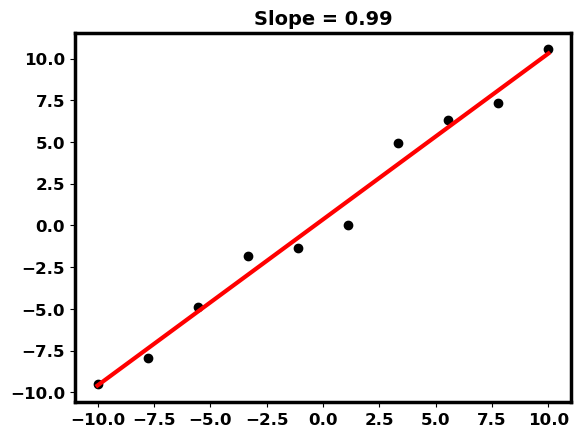

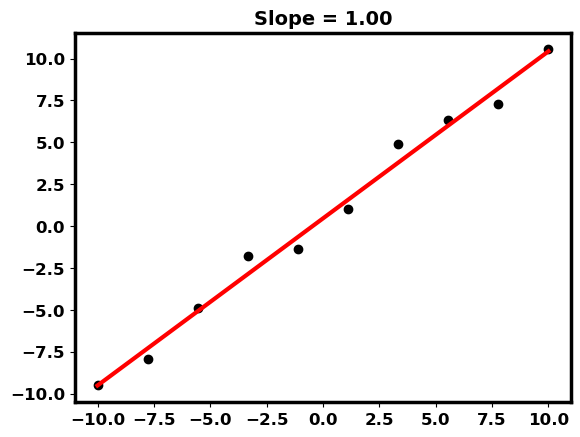

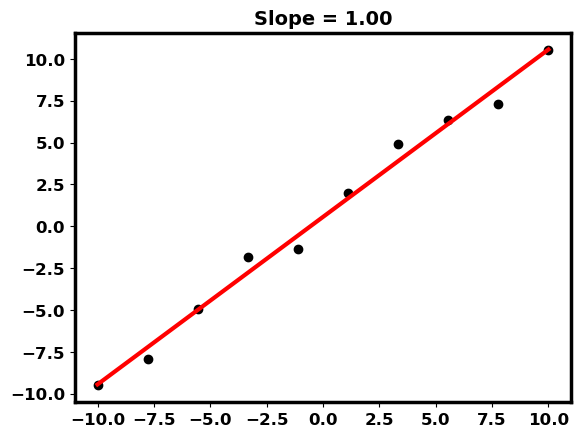

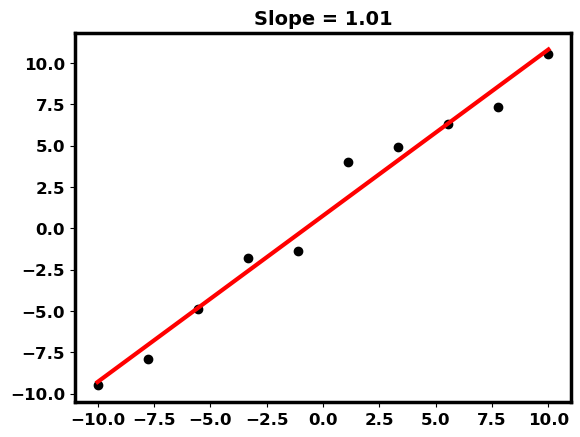

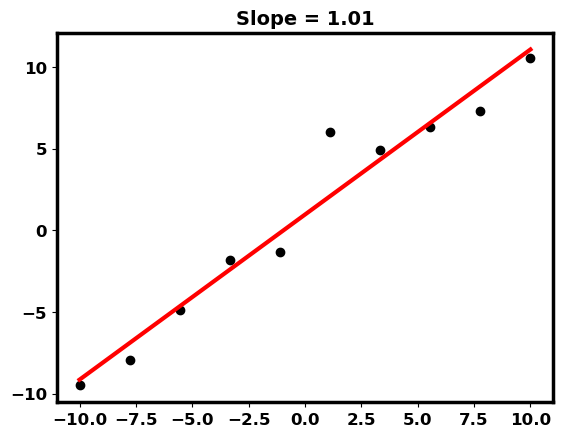

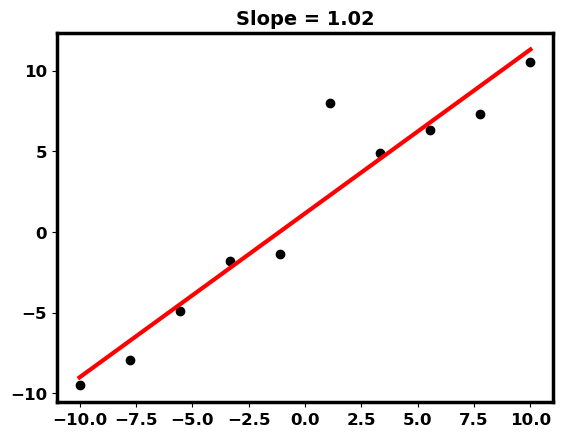

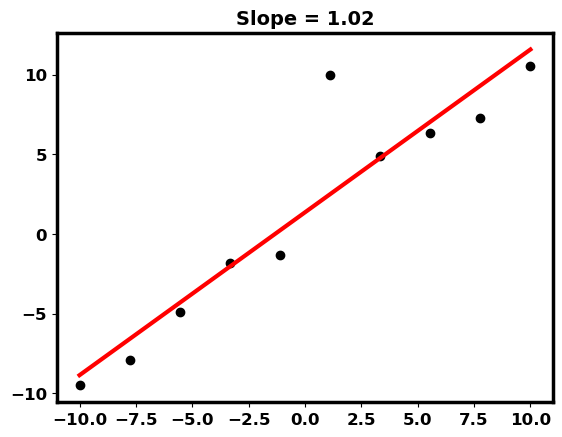

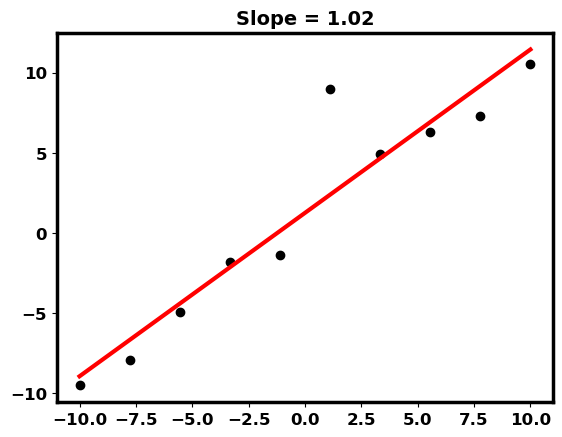

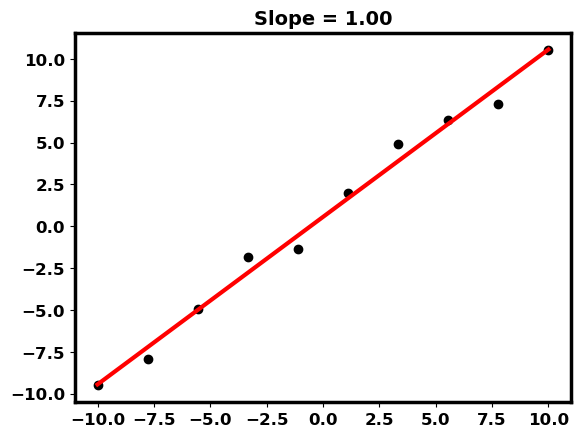

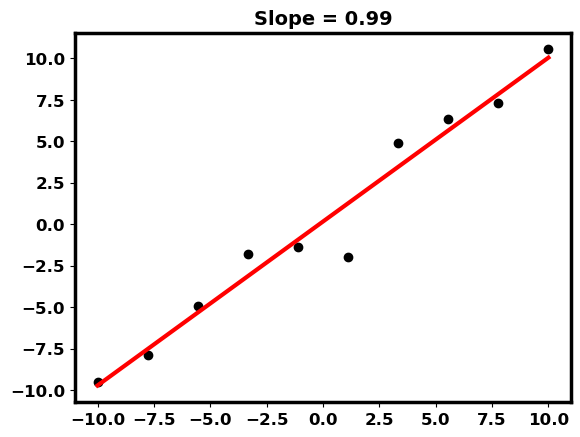

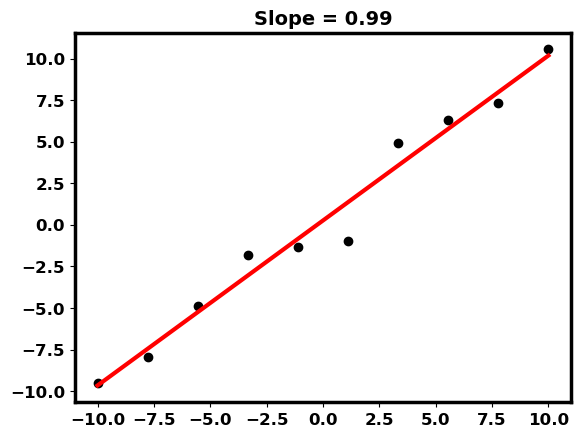

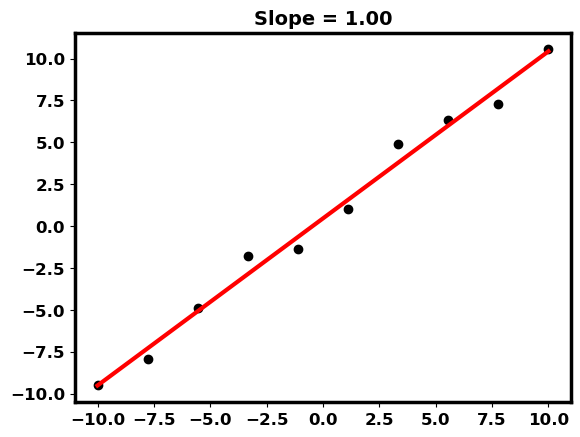

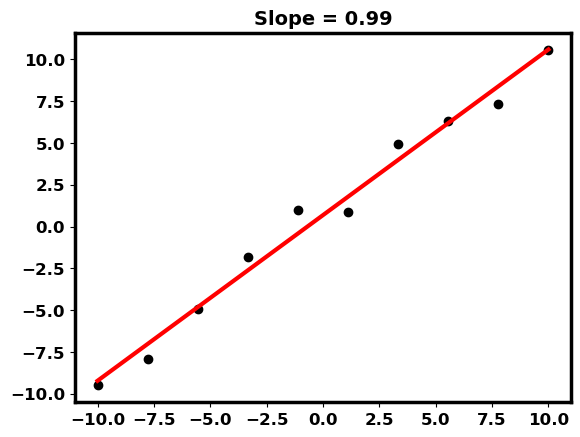

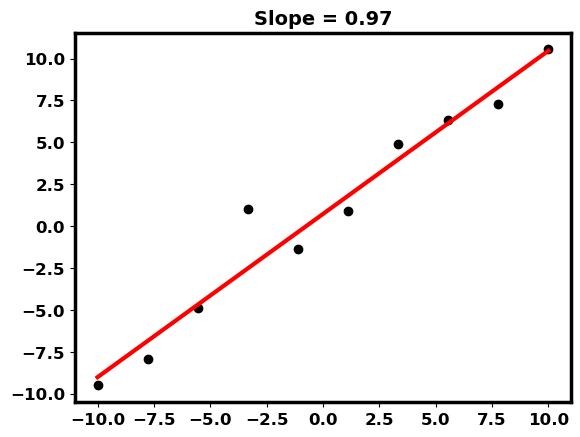

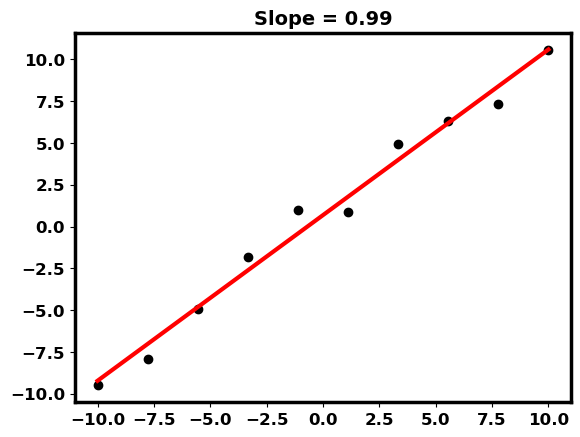

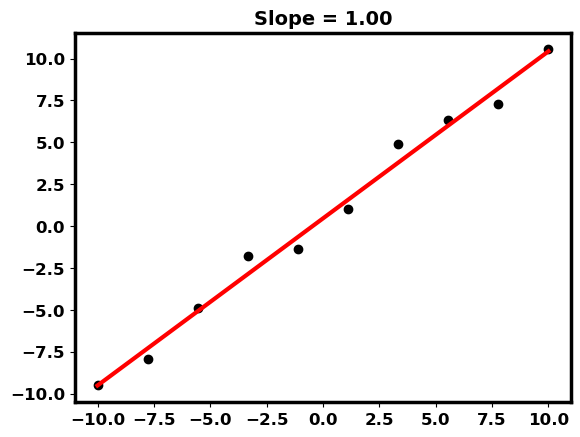

In [5]:
iph.plot_interact(fit_update)

Play around with the tool
- Choose an index near the middle (set top slider to a value of around 5)
    - Move the bottom slider, observing the effect on the fitted line (slope displayed in the title)
- Choose an index at either extreme (index 0 or 9)
    - Move the bottom slider, observing the effect on the fitted line (slope displayed in the title)

Observe 
- Changing $\y^\ip$ for $i$ near the middle of the range has little effect on the fit
- Changing $\y^\ip$ for $i$ near either end ($0$ or $9$) has a large effect on the fit


The solution is to somehow reduce example $i$'s contribution to Average Loss
- Removing the example: possible data error or outlier
- Down-weighting
- Clipping the values of the features/target to some upper bound


### Further background 

Consider feature $j$.

The **leverage** of example $i$ is related to
- How far $\x_j^\ip$ is from $\bar{\x}$, the average of $\x_j$ across all examples

It is not always the case, but high leverage sometimes makes the point influential

Reference:
[Influence from leverage and distance](http://onlinestatbook.com/2/regression/influential.html)
>An observation's influence is a function of two factors: (1) how much the observation's value on the predictor variable differs from the mean of the predictor variable and (2) the difference between the predicted score for the observation and its actual score. The former factor is called the observation's leverage. The latter factor is called the observation's distance.

Calculation of Leverage (h) of example $i$, feature $j$

[formula](https://learnche.org/pid/least-squares-modelling/outliers-discrepancy-leverage-and-influence-of-the-observations#leverage)

$$ 
\begin{array}{lll}
h^\ip_j & = & { 1 \over n }+ \frac{ (\x^\ip_j - \bar{\x_j})^2}{ \sum_i { (\x^\ip_j - \bar{\x_j})^2} } \\
    & = & \frac{ 1 + \left( \frac{\x^\ip_j - \bar{\x_j}}{\sigma_{\x_j} } \right) ^2}{n}
\end{array}
$$

You can see that the leverage of $\x^\ip_j$ depends on the (standardized) distance of $\x^\ip_j$ from the mean (over all $i$) of $\x_i$.

In [6]:
print("Done")

Done
